In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import random
import copy
import os
from scipy import stats
import pandas as pd

from utils import HandlingNets
from models import PositionalEncoding
from models import TransformerModel
from models import LSTMModel
from utils import get_data_tensor
#from utils import ma
from utils import get_net_output

### General settings

In [2]:
model_type = 'Transformer' # 'LSTM', 'Transformer'

measure_level = 'L2'

measure_mode = 'theta' # 'theta' ONLY!

output_mode = 'r' # 'r', 'dr', 'drrel'

output_tanh = 0 # 0: 'linear', >0: 'tanh', only used wiyth Transformer

continent_knockout = '' # '': all, 'NoEurope', 'NoAsia', 'NoAmerica'

### Reading Data

In [3]:
filename = './Data/data.pkl'
with open(filename, 'rb') as f:
    data = pickle.load(f)

### Nets file name

In [4]:
emsize = 128
precoder_size = 0

n_layers = 2
hidden_size = 100

In [5]:
file_net = model_type + '_' + measure_level + '_' + measure_mode + '_' + output_mode
if model_type == 'Transformer':
    file_net += '_' + str(emsize)
    if precoder_size > 0:
        file_net += '_tanh' + str(precoder_size)
elif model_type == 'LSTM':
    file_net += '_' + str(n_layers) + 'x' + str(hidden_size)
if len(continent_knockout) > 0:
    file_net += '_' + continent_knockout
file_net += '.pt'

### Loading HandlingNets file

In [6]:
#hn = HandlingNets(measure_mode=measure_mode)
hn = HandlingNets()
hn.load_saved_nets(file_net)
config = hn.config
cuda = config['train']['cuda']
countries = hn.countries

ind_min_loss = np.argmin(np.array(hn.nets_min_test_loss))

<BarContainer object of 20 artists>

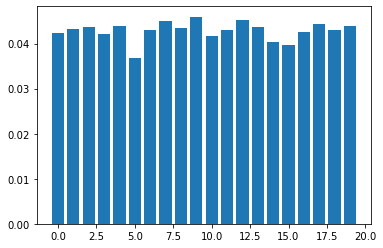

In [7]:
plt.bar(range(len(hn.nets_min_test_loss)), hn.nets_min_test_loss)

### Knockout function for a single country

In [15]:
def knockout(country, data, hn, knockout_npi_index, n_days=20, n_best=-1, mode='prediction'):
    # n_best:
    #     if int: the best n_best networks are selected (-1: all nets)
    #     if list: the networks with the indexes contained in n_best are selected
    
    
    measure_mode = hn.measure_mode
    output_mode = hn.output_mode
    cuda = hn.config['train']['cuda']
    
    if type(n_best) == int:
        nets_min_test_loss = np.array(hn.nets_min_test_loss)
        ind_best = np.argsort(np.array(nets_min_test_loss))
        if n_best == -1:
            n_best = len(nets_min_test_loss)
    elif type(n_best) == list:
        ind_best = n_best.copy()
        n_best = len(n_best)
    else:
        raise ValueError('n_best must be either int or list')
    
    out_nn = []
    out_nn_ko = []
    
    for k_net, ind_net in enumerate(ind_best[:n_best]):
        best_state_dict = hn.nets_best_state_dict[ind_net]
        if model_type == 'Transformer':
            model = TransformerModel(config)
        elif model_type == 'LSTM':
            model = LSTMModel(config)
            
        _ = model.load_state_dict(best_state_dict)    
        
        if cuda:
            model = model.cuda()
        
        
        model.eval()
        
        inp0, target = get_data_tensor(data, country, measure_mode, output_mode=output_mode, cuda=cuda)
            
        # Knockout is performed only if the specific measure is present for that country
        if inp0[:,0,knockout_npi_index].sum().item() > 0.0:
            
            if knockout_npi_index >= 0:

                starting_day = inp0[:,0,knockout_npi_index].cpu().numpy()
                starting_day = np.where(starting_day==0)[0]
                if len(starting_day) == 0:
                    starting_day = 0
                else:
                    starting_day = starting_day[-1] + 1

                # Normal input
                inp = inp0.clone()
                if mode == 'prediction':
                    out, _ = get_net_output(inp, model_type, model, cuda)
                    out = out.flatten().detach().cpu().numpy()
                    
                elif mode == 'evolution':
                    if starting_day > 0:
                        out_temp, _ = get_net_output(inp[:starting_day], model_type, model, cuda)
                        out = out_temp.flatten().detach().cpu().tolist()
                    else:
                        out = [inp0[0,0,-1].item()]
                        
                    for k in range(starting_day, starting_day+n_days+1):
                        if k < inp.shape[0]:
                            inp[k,0,-1] = torch.FloatTensor([out[-1]])
                            if k > 0:
                                out_temp, _ = get_net_output(inp[:k], model_type, model, cuda)
                            else:
                                out_temp, _ = get_net_output(inp[k].view(1,1,-1), model_type, model, cuda)
                            out_temp = out_temp.flatten().detach().cpu().tolist()
                            out.append(out_temp[-1])
                    out = np.array(out)
                else:
                    raise ValueError('mode: prediction or evolution')
                
                if len(out) >= starting_day+n_days:
                    out_nn.append(out[starting_day:starting_day+n_days])
                else:
                    out_temp = np.zeros(starting_day+n_days)
                    out_temp[:] = np.nan
                    out_temp[:len(out)] = out
                    out_temp = out_temp[starting_day:starting_day+n_days]
                    out_nn.append(out_temp)

                # Knockout input
                inp_ko = inp0.clone()
                inp_ko[:,:,knockout_npi_index] = 0.0
                
                if mode == 'prediction':
                    out, _ = get_net_output(inp_ko, model_type, model, cuda)
                    out = out.flatten().detach().cpu().numpy()
                elif mode == 'evolution':
                    if starting_day > 0:
                        out_temp, _ = get_net_output(inp_ko[:starting_day], model_type, model, cuda)
                        out = out_temp.flatten().detach().cpu().tolist()
                    else:
                        out = [inp0[0,0,-1].item()]
                    for k in range(starting_day, starting_day+n_days+1):
                        if k < inp.shape[0]:
                            inp_ko[k,0,-1] = torch.FloatTensor([out[-1]])
                            if k > 0:
                                out_temp, _ = get_net_output(inp_ko[:k], model_type, model, cuda)
                            else:
                                out_temp, _ = get_net_output(inp_ko[k].view(1,1,-1), model_type, model, cuda)
                            out_temp = out_temp.flatten().detach().cpu().tolist()
                            out.append(out_temp[-1])
                    out = np.array(out)
                else:
                    raise ValueError('mode: prediction or evolution')
                

                if len(out) >= starting_day+n_days:
                    out_nn_ko.append(out[starting_day:starting_day+n_days])
                else:
                    out_temp = np.zeros(starting_day+n_days)
                    out_temp[:] = np.nan
                    out_temp[:len(out)] = out
                    out_temp = out_temp[starting_day:starting_day+n_days]
                    out_nn_ko.append(out_temp)

    return np.array(out_nn), np.array(out_nn_ko)

In [16]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

### Knockout for all NPIs and countries

In [17]:
#mode = 'prediction'
mode = 'evolution'

out_nn_mean = []
out_nn_std = []
out_nn_ko_mean = []
out_nn_ko_std = []
diff_mean = []
diff_std = []
diff_ci = []

for npi, npi_name in enumerate(data['L1L2_names']):
    print(npi_name)
    
    out_nn = []
    out_nn_ko = []
    for country in countries:
        out, out_ko = knockout(country, data, hn, npi, n_days=20, n_best=-1, mode=mode)
        if len(out) > 0:
            out_nn.append(out)
            out_nn_ko.append(out_ko)
    out_nn = np.array(out_nn)
    out_nn_ko = np.array(out_nn_ko)
        
    out_nn_mean.append(np.nanmean(out_nn.flatten(), axis=0))
    out_nn_std.append(np.nanstd(out_nn.flatten(), axis=0))
    out_nn_ko_mean.append(np.nanmean(out_nn_ko.flatten(), axis=0))
    out_nn_ko_std.append(np.nanstd(out_nn_ko.flatten(), axis=0))
    
    diff_std.append(np.nanstd(out_nn.flatten() - out_nn_ko.flatten()))
    
    diff = out_nn.flatten() - out_nn_ko.flatten()
    diff = diff[~np.isnan(diff)]
    m, h = mean_confidence_interval(diff, confidence=0.95)
    diff_mean.append(m)
    diff_ci.append(h)

ActivateCaseNotification
ActivateOrEstablishEmergencyResponse
ActivelyCommunicateWithHealthcareProfessionals1
ActivelyCommunicateWithManagers1
AdaptProceduresForPatientManagement
AirportHealthCheck
AirportRestriction
BorderHealthCheck
BorderRestriction
ClosureOfEducationalInstitutions
CordonSanitaire
CrisisManagementPlans
EducateAndActivelyCommunicateWithThePublic1
EnhanceDetectionSystem
EnhanceLaboratoryTestingCapacity
EnvironmentalCleaningAndDisinfection
IncreaseAvailabilityOfPpe
IncreaseHealthcareWorkforce
IncreaseInMedicalSuppliesAndEquipment
IncreaseIsolationAndQuarantineFacilities
IncreasePatientCapacity
IndividualMovementRestrictions
IsolationOfCases
MassGatheringCancellation
MeasuresForPublicTransport
MeasuresForSpecialPopulations
MeasuresToEnsureSecurityOfSupply
NationalLockdown
PersonalProtectiveMeasures
PoliceAndArmyInterventions
PortAndShipRestriction
ProvideInternationalHelp
PublicTransportRestriction
Quarantine
ReceiveInternationalHelp
RepurposeHospitals
Research
Restrict

In [18]:
l2_names = data['L1L2_names']

In [20]:
diff_mean = np.array(diff_mean)
ind_rank = np.argsort(diff_mean)
rank = np.zeros_like(diff_mean).astype(int)
for r in range(len(diff_mean)):
    rank[ind_rank[r]] = r + 1


In [21]:
df = pd.DataFrame({'L2': l2_names, 'Rank': rank, 'Delta R': diff_mean, 'CI': diff_ci})

In [22]:
df.style.hide_index()

L2,Rank,Delta R,CI
ActivateCaseNotification,34,0.014948,0.003275
ActivateOrEstablishEmergencyResponse,14,-0.120630,0.001975
ActivelyCommunicateWithHealthcareProfessionals1,32,-0.002858,0.001707
ActivelyCommunicateWithManagers1,39,0.049816,0.002008
AdaptProceduresForPatientManagement,18,-0.087380,0.002346
AirportHealthCheck,36,0.025611,0.002175
AirportRestriction,1,-0.340065,0.003389
BorderHealthCheck,21,-0.074039,0.003648
BorderRestriction,23,-0.057237,0.002007
ClosureOfEducationalInstitutions,10,-0.145846,0.001823


In [23]:
df.sort_values(['Delta R'], ascending=True).style.hide_index()

L2,Rank,Delta R,CI
AirportRestriction,1,-0.340065,0.003389
SmallGatheringCancellation,2,-0.326664,0.003034
EducateAndActivelyCommunicateWithThePublic1,3,-0.276118,0.002389
ProvideInternationalHelp,4,-0.240390,0.007231
IncreaseInMedicalSuppliesAndEquipment,5,-0.200485,0.003012
IncreasePatientCapacity,6,-0.177947,0.002565
RestrictedTesting,7,-0.164816,0.006460
TravelAlertAndWarning,8,-0.158829,0.003238
MeasuresToEnsureSecurityOfSupply,9,-0.150123,0.002885
ClosureOfEducationalInstitutions,10,-0.145846,0.001823


In [24]:
save_csv = True

csv_filename = model_type + '_' + measure_level + '_' + measure_mode + '_' + output_mode

if model_type == 'Transformer':
    csv_filename += '_' + str(emsize)
elif model_type == 'LSTM':
    csv_filename += '_' + str(n_layers) + 'x' + str(hidden_size)

csv_filename += '_' + mode
    
if len(continent_knockout) > 0:
    csv_filename += '_' + continent_knockout
csv_filename += '.csv'    

if save_csv:
    df.to_csv(csv_filename, index=False)